In [1]:
import numpy as np
import seaborn as sns
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

G = 6.67e-11
c = 2.998e8
Msun = 2e30
Rsun = 7e8
year = 3600.*24.*365
kpc = 1e3*3.086e16

In [2]:
# for Mathieu's OCD
import sys
sys.path.append('/mnt/home/mrenzo/codes/python_stuff/plotFunc/')
from plotDefaults import set_plotDefaults


In [3]:
set_plotDefaults()

done in plotDefaults.py


# Helper Functions

At lowest PN order, a compact binary's frequency evolves as (Maggiore Eq. 4.18)
\begin{equation}
{\dot f}_{\rm gw} = \frac{96}{5} \pi^{8/3} \left(\frac{G \mathcal{M}}{c^3}\right)^{5/3} f_{\rm gw}^{11/3}
\end{equation}

We will need an expression for the strain amplitude of a quasi-circular face-on compact binary. Consider a toy binary with chirp mass $\mathcal{M}$ at distance $D$. Neglecting evolution, the plus- and cross-polarizations will each have amplitude (Maggiore Eq. 4.3):
\begin{equation}
\begin{aligned}
A(t) &= \frac{4}{D} \left(\frac{G \mathcal{M}_c}{c^2} \right)^{5/3} \left(\frac{2\pi f_\mathrm{orb}}{c}\right)^{2/3} \\
&= \frac{4}{D} \left(\frac{G \mathcal{M}_c}{c^2} \right)^{5/3} \left(\frac{\pi f_\mathrm{gw}}{c}\right)^{2/3}
\end{aligned}
\end{equation}

In [4]:
def compute_Mc(m1,m2):
    
    """
    Returns chirp mass, given binary component masses
    """
    
    Mtot = m1+m2
    eta = (m1*m2)/np.power(m1+m2,2.)
    return np.power(eta,3./5.)*Mtot

def fdotGW_from_fGW_Mc(f_gw,Mc):
    
    """
    Returns df/dt assuming *purely gravitational-wave-driven evolution*, given a present GW frequency
    (i.e. twice the present orbital frequency) and a binary chirp mass.
    See Eq. 4.18 of Maggiore
    """
    
    return (96./5.)*np.power(np.pi,8./3.)*np.power(G*Mc*Msun/c**3.,5./3.)*np.power(f_gw,11./3.)

def amp_from_fGW_mass_dist(f_gw,Mc,D):
    
    """
    Gravitational wave amplitude given a present GW frequency, binary chirp mass, and source distance.
    See Eq. 4.3 of Maggiore
    """
    
    return (4./(D*kpc))*np.power(G*Mc*Msun/c**2.,5./3.)*np.power(np.pi*f_gw/c,2./3.)

def a_from_fGW_mass(f_gw,m1,m2):
    
    """
    Binary separation, given current GW frequency and component masses.
    This is just Kepler's Law...
    """
    
    return np.power(G*(m1+m2)*Msun/(np.pi*f_gw)**2,1./3.)

Let's define the LISA PSD. I'll follow Eq. 1 of [Robson et al](https://arxiv.org/pdf/1803.01944.pdf)

/mnt/home/mrenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/mnt/home/mrenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'PSD')

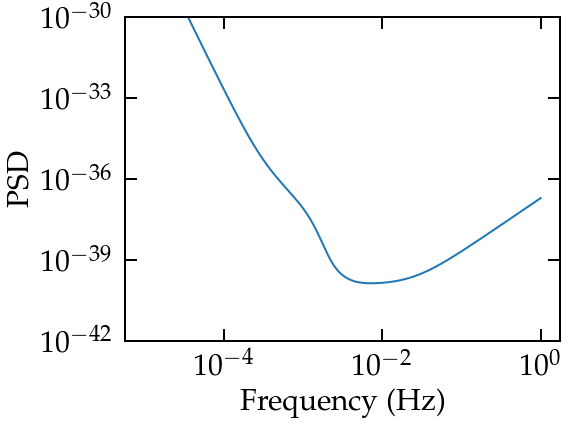

In [5]:
# https://arxiv.org/pdf/1803.01944.pdf

L_arm = 2.5e9
fref = 19.09e-3
def LISA_sensitivity(f):
    
    # Instrumental noise
    P_oms = np.power(1.5e-11,2.)*(1.+np.power(2.e-3/f,4.))
    P_acc = np.power(3.e-15,2.)*(1.+np.power(0.4e-3/f,2.))*(1.+np.power(f/8e-3,4))
    S_n = (10./(3.*L_arm*L_arm))*(P_oms + 4.*P_acc/np.power(2.*np.pi*f,4.))*(1.+(3./5.)*np.power(f/fref,2.))
    
    # Confusion noise (assume four years)
    A = 9e-45
    alpha = 0.138
    beta = -221.
    k = 521.
    gamma = 1680.
    fk = 1.13e-3
    S_conf = A*np.power(f,-7./3.)*np.exp(-f**alpha+beta*f*np.sin(k*f))*(1.+np.tanh(gamma*(fk-f)))
    
    # Impose upper frequency limit
    S_n[f>=1.] = np.inf
    S_conf[f>=1.] = np.inf
    
    return S_n + S_conf

f = np.logspace(-5,2,1000)
strain_sensitivity = LISA_sensitivity(f)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(f,strain_sensitivity,lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-42,1e-30)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')

### LISA Signal-To-Noise

Averaging over sky position and binary inclination angles, the mean squared-SNR of a binary signal is

\begin{equation}
\langle \mathrm{SNR}\rangle^2 = \frac{16}{5} \int_0^\infty \frac{\mathcal{R} A^2(f)}{P_n(f)} df,
\end{equation}

where $A(f)$ is the strain amplitude of a face-on binary, $P_n(f)$ is the noise power spectral density in the detector, and $\mathcal{R}$ is the sky-averaged response function of the LISA detector.
In the low-frequency limit (and after adding LISA's multiple channels), $\mathcal{R} \approx \frac{3}{10}$; see Robson's Eq. 8.
Rearranging slightly,
\begin{equation}
\begin{aligned}
\langle \mathrm{SNR}\rangle^2 &= \frac{16}{5} \int_0^\infty \frac{A^2(f)}{P_n(f)/\mathcal{R}} df, \\
    &= \frac{16}{5} \int_0^\infty \frac{A^2(f)}{S_n(f)} df,
\end{aligned}
\end{equation}
where $S_n(f)$ is the LISA equivalent strain sensitivity (i.e. the *physical* strain power of incident GWs that is equivalent to the noise power in the instrument).

In [6]:
def snr_from_f_fdot(f0,fdot0,m1=1.,m2=1.,D=3.):
    
    # We'll truncate any frequency evolution at f = 3e-2 Hz,
    # above which we expect tidal disruption of binaries.
    # If we're *already* above this limit, then return vanishing SNR
    if f0>=3e-2:
        return 0.
    
    # Otherwise create a grid between f0 and the final observed frequency:
    # the disruption frequency or f(t=0) + (df/dt)*(5 years), whichever is lowest
    f_final = min(3e-2,f0+fdot0*5.*year)
    fourier_freqs = np.arange(f0,f_final,(f_final-f0)/1000.)
    
    # Calculate the corresponding GW amplitudes and orbital separations as
    # a function of these (GW) frequencies
    amp_at_f = amp_from_fGW_mass_dist(fourier_freqs,compute_Mc(m1,m2),D)
    sep_at_f = a_from_fGW_mass(fourier_freqs,m1,m2)

    # Get the Fourier amplitude at each frequency, as given by the SPA
    # (e.g. Eq. 3.14 of 10.1103/PhysRevD.80.084043).
    # Note that, for lack of a better option, we are assuming constant fdot
    fdot_at_f = fdot0
    hf = amp_at_f/np.sqrt(fdot_at_f)
    
    PSD = LISA_sensitivity(fourier_freqs)
    rho2 = (16./5.)*np.trapz(np.power(hf,2.)/PSD,fourier_freqs)

    return np.sqrt(rho2)

In [7]:
# Load file with gas drag data
f_ref, fdot_drag = np.loadtxt('fdot_and_f_m1_0.5_m2_0.3.txt',unpack=True,usecols=(0,2))

# Verification binary data from Kupfer+ 2018
# GW frequencies are taken from Table 2
# Masses are from Table 1 (when an uncertain range is provided, take the average)
wd_fs = np.array([6.22,3.51,3.22,2.12,1.94,1.84,1.81,1.48,1.45,1.36,1.25,2.61,1.68,0.84,0.51,0.47])*1e-3
wd_m1s,wd_m2s = np.transpose(np.array([\
                                 [0.55,0.27],\
                                 [0.8,0.177],\
                                 [0.8,0.161],\
                                 [0.8,0.1],\
                                 [0.68,0.125],\
                                 [0.8,0.085],\
                                 [(0.8+0.49)/2., (0.088+0.048)/2.],\
                                 [0.8,0.066],\
                                 [0.8,0.064],\
                                 [(1.1+0.67)/2., (0.088+0.044)/2.],\
                                 [(1.17+0.78)/2., (0.109+0.059)/2.],\
                                 [0.247,0.49],\
                                 [0.312,0.75],\
                                 [0.298,0.76],\
                                 [0.275,0.76],\
                                 [0.54,0.79]
                                ])
                          )

wd_etas = wd_m1s*wd_m2s/(wd_m1s+wd_m2s)**2.
wd_Mcs = np.power(wd_etas,3./5.)*(wd_m1s+wd_m2s)

In [ ]:
# Loop across initial observed GW frequencies and frequency derivatives
# Calculate sky-averaged SNR for each, assuming a 0.5+0.3 system at 3 kpc
f_orbs = np.logspace(-4.,-1.5,200)
fdot_orbs = np.logspace(-20,6,190)
rhos = np.zeros((f_orbs.size,fdot_orbs.size))
for i in range(f_orbs.size):
    for j in range(fdot_orbs.size):
        rhos[i,j] = snr_from_f_fdot(f_orbs[i],fdot_orbs[j],0.5,0.3)

# Create colormap and label a few contours
fig,ax = plt.subplots(figsize=(8,6))
PS = ax.pcolormesh(np.log10(f_orbs),np.log10(fdot_orbs),np.log10(rhos).T,cmap='Blues',vmin=0)
CS = ax.contour(np.log10(f_orbs),np.log10(fdot_orbs),rhos.T,levels=[1,10,100,300],colors='black')

# Plot phase space locations of verification binaries
ax.scatter(np.log10(wd_fs),np.log10(fdotGW_from_fGW_Mc(wd_fs,wd_Mcs)),marker='x',color='black')

# Plot bounds from pure gas and pure GW-driven evolution
xs = 10.**np.linspace(-4,0,100)
ys = fdotGW_from_fGW_Mc(xs,compute_Mc(0.5,0.3))
ax.plot(np.log10(f_ref),np.log10(fdot_drag),lw=2,color='orange',label='Pure Gas Drag')
ax.plot(np.log10(xs),np.log10(ys),lw=2,color='orange',ls='--',label='Pure GW Emission')

ax.clabel(CS, inline=1, fontsize=14, fmt="%.0f", inline_spacing=5)
ax.set_xlabel(r'$\log_{10}(f_\mathrm{GW}) [\mathrm{Hz}]$',fontsize=30)
ax.set_ylabel(r'$\log_{10}|\dot f_\mathrm{GW}|\,[\mathrm{s}^{-2}]$',fontsize=30)
ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="$\log_{10}(\mathrm{SNR})$",fontsize=30)
ax.set_ylim(-20,-5)

fdot_min = 1./(5.*year)**2.
fddot_min = (2./(5.*year))/(5.*year)**2.
fdot_at_minimum_fddot = np.sqrt((3./11.)*xs*fddot_min)
ls1, = ax.plot(np.log10(xs),np.log10(fdot_at_minimum_fddot),color='black',dashes=(4,2,2,2))
ls2 = ax.axhline(y=np.log10(fdot_min),color='black',ls=':',lw=1.5)

ax.fill_betweenx([-20,-1],-1.5,1.0,color='white')
ax.axvline(x=-1.5,color='black')
ax.set_xlim(-4,-1)

leg = plt.legend([ls1,ls2], ["$\ddot f_\mathrm{GW}$ Measurable", "$\dot f_\mathrm{GW}$ Measurable"], fontsize=14,
                 frameon=True,framealpha=1,loc=(0.45,0.85))
ax.add_artist(leg)

plt.legend(loc='upper left',fontsize=14,frameon=True,framealpha=1)
plt.tight_layout()
plt.savefig('snr_grid.pdf',bbox_inches='tight')

# Scratch

In [12]:
f_orbs = np.logspace(-4.,0,90)
fdot_orbs = np.logspace(-20,6,90)
rhos = np.zeros((f_orbs.size,fdot_orbs.size))
for i in range(f_orbs.size):
    for j in range(fdot_orbs.size):
        rhos[i,j] = snr_from_f_fdot(f_orbs[i],fdot_orbs[j],0.5,0.3)

fig,ax = plt.subplots(figsize=(8,6))

PS = ax.pcolormesh(np.log10(f_orbs),np.log10(fdot_orbs),np.log10(rhos).T,cmap='Blues',vmin=0)
CS = ax.contour(np.log10(f_orbs),np.log10(fdot_orbs),rhos.T,levels=[1,10,100,300],colors='black')

ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'Log10 $f$ (Hz)',fontsize=16)
ax.set_ylabel(r'Log10 $|\dot f|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.scatter(np.log10(wd_fs),np.log10((96./5.)*np.power(np.pi,8./3.)*np.power(c,-5.)*np.power(G*Mcs*Msun,5./3.)*np.power(wd_fs,11./3.)),marker='x',color='black')
ax.plot(np.log10(f_ref),np.log10(fdot_drag),lw=2,color='orange')

xs = 10.**np.linspace(-4,0,100)
ys = fdotGW_from_fGW_Mc(xs,compute_Mc(0.5,0.3))
ax.plot(np.log10(xs),np.log10(ys),lw=2,color='orange',ls='--')

ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)
ax.set_ylim(-20,-5)

fddot_min = (2./(5.*year))/(5.*year)**2.
fdot_at_minimum_fddot = np.sqrt((3./11.)*xs*fddot_min)
ax.plot(np.log10(xs),np.log10(fdot_at_minimum_fddot),color='black',dashes=(4,2,2,2))

ax.set_xlim(-4,-1)

NameError: name 'amp_from_fGW_mass_dist' is not defined

From Maggiore, we have 

\begin{equation}
\dot f_\mathrm{gw} = \frac{96}{5} \pi^{8/3} \left(\frac{G \mathcal{M}_c}{c^3}\right)^{5/3} f_\mathrm{gw}^{11/3}
\end{equation}

Then

\begin{equation}
\begin{aligned}
\ddot f_\mathrm{gw}
&= \frac{96}{5} \pi^{8/3} \left(\frac{G \mathcal{M}_c}{c^3}\right)^{5/3} \frac{11}{3} f_\mathrm{gw}^{8/3} \dot f_\mathrm{gw} \\
&= \Big[\frac{96}{5} \pi^{8/3} \left(\frac{G \mathcal{M}_c}{c^3}\right)^{5/3} f_\mathrm{gw}^{11/3} \Big] \frac{11}{3} f_\mathrm{gw}^{-1} \dot f_\mathrm{gw} \\
&= \frac{11}{3} \frac{\dot f_\mathrm{gw}^2}{f}
\end{aligned}
\end{equation}

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


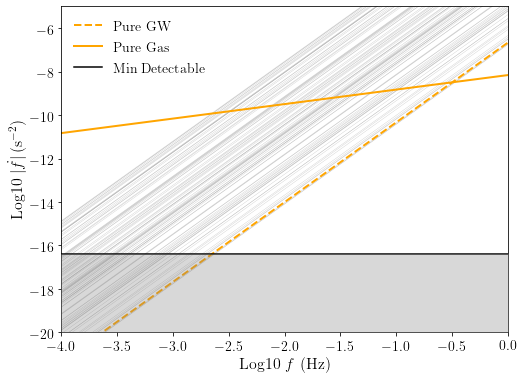

In [8]:
fig,ax = plt.subplots(figsize=(8,6))

fs = np.array([])
fdots = np.array([])

for i in range(100):
    
    Mtot = 10.**(np.random.random()*4)
    m1 = Mtot/2.
    m2 = Mtot/2.
    
    fISCO = 2.2e3/Mtot
    
    fs = np.logspace(-4,np.log10(fISCO))
    fdot = fdotGW_from_fGW_Mc(fs,compute_Mc(m1,m2))
       
    ax.plot(np.log10(fs),np.log10(fdot),color='grey',alpha=0.5,lw=0.3)
    
xs = 10.**np.linspace(-4,0,100)
ys = fdotGW_from_fGW_Mc(xs,compute_Mc(0.5,0.8))
ax.plot(np.log10(xs),np.log10(ys),lw=2,color='orange',ls='--',label='Pure GW')

ax.plot(np.log10(f_ref),np.log10(fdot_drag),lw=2,color='orange',label='Pure Gas')

fdot_min = (1./(5.*year))/(5.*year)
ax.axhline(y=np.log10(fdot_min),color='black',label='Min Detectable')
ax.fill_between([-4,0],[np.log10(fdot_min),np.log10(fdot_min)],[-20,-20],color='grey',zorder=5,alpha=0.3)

ax.set_xlim(-4,0)
ax.set_ylim(-20,-5)
ax.set_xlabel(r'Log10 $f$ (Hz)',fontsize=16)
ax.set_ylabel(r'Log10 $|\dot f|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14,frameon=False)

In [24]:
fdot_min = (1./(5.*year))/(5.*year)
print(fdot_min)

4.022043630614483e-17


[0.58740105 0.62074139 0.63424119 ... 0.66665555 0.66665555 0.66665555]
5.101526675056422e-25


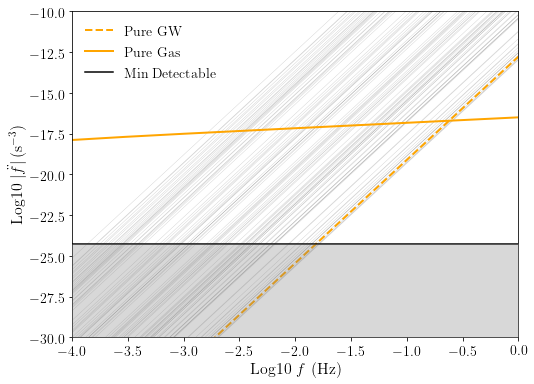

In [18]:
fig,ax = plt.subplots(figsize=(8,6))

fs = np.array([])
fdots = np.array([])

for i in range(100):
    
    Mtot = 10.**(np.random.random()*4)
    m1 = Mtot/2.
    m2 = Mtot/2.
    
    fISCO = 2.2e3/Mtot
    
    fs = np.logspace(-4,np.log10(fISCO))
    fdot = fdotGW_from_fGW_Mc(fs,compute_Mc(m1,m2))
    fddot = (11./3.)*fdot**2./fs
       
    ax.plot(np.log10(fs),np.log10(fddot),color='grey',alpha=0.5,lw=0.3)

"""
Mtot = 100.
fISCO = 2.2e3/Mtot
fs = np.logspace(-4,np.log10(fISCO))
fdot = fdotGW_from_fGW_Mc(fs,compute_Mc(m1,m2))
fddot = (11./3.)*fdot**2./fs
ax.plot(np.log10(fs),np.log10(fddot),color='blue')
"""

xs = 10.**np.linspace(-4,0,100)
ys = fdotGW_from_fGW_Mc(xs,compute_Mc(0.5,0.8))
ax.plot(np.log10(xs),np.log10((11./3.)*ys**2./xs),lw=2,color='orange',ls='--',label='Pure GW')

dfdot_df_drag = (fdot_drag[1:]-fdot_drag[:-1])/(f_ref[1]-f_ref[0])
fddot_drag = fdot_drag[:-1]*dfdot_df_drag

ax.plot(np.log10(f_ref[:-1]),np.log10(fddot_drag),lw=2,color='orange',label='Pure Gas')
print(fddot_drag*f_ref[:-1]/fdot_drag[:-1]**2.)

fdot_min = (1./(5.*year))/(5.*year)

fddot_min = (2./(5.*year))/(5.*year)**2.
ax.axhline(y=np.log10(fddot_min),color='black',label='Min Detectable')
ax.fill_between([-4,0],[np.log10(fddot_min),np.log10(fddot_min)],[-30,-30],color='grey',zorder=5,alpha=0.3)
print(fddot_min)

    
ax.set_xlim(-4,0)
ax.set_ylim(-30,-10)
ax.set_xlabel(r'Log10 $f$ (Hz)',fontsize=16)
ax.set_ylabel(r'Log10 $|\ddot f|\,(\mathrm{s}^{-3})$',fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14,frameon=False)

### Consistency Test: Braking Index

Pulsar astronomy: Pulsar frequencies evolve as

\begin{equation}
\dot f \propto f^n
\end{equation}

for some braking index $n$. Evolution that's purely driven by dipole radiation gives $n=3$, while evolution driven purely by GW emission gives $n=5$.

Given measurements of $f$, $\dot f$, and $\ddot f$, the braking index can be *measured* via

\begin{equation}
n = \frac{f \ddot f}{\dot f^2}.
\end{equation}

We're in an analogous situation. Compact binaries evolving purely under GW emission have frequency evolution (lowest PN order)

\begin{equation}
\dot f \propto f^{11/3}
\end{equation}

such that

\begin{equation}
n_\mathrm{GW} = 11/3.
\end{equation}

Binaries evolving under pure gas drag will have

\begin{equation}
n_\mathrm{gas}\approx 0.6.
\end{equation}

So binaries in the midst of CE will generically have $n_\mathrm{gas}\leq n \leq g_\mathrm{GW}$. Given LISA measurements of $f$, $\dot f$, and $\ddot f$, we can compute the binary's $n$ and see if it is consistent (or not!) with $n_\mathrm{GW}$.

/Users/tcallister/miniconda3/envs/work-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'inline'
  
No handles with labels found to put in legend.




Min fdot:	4.022043630614483e-17
Min fddot:	5.101526675056422e-25


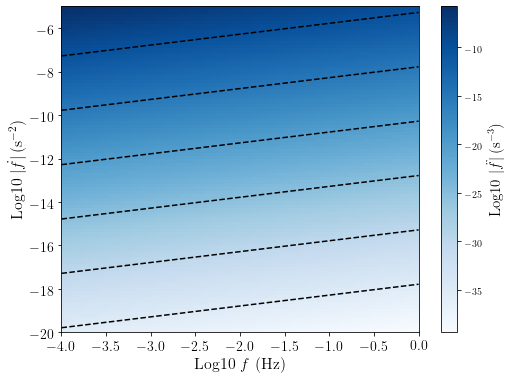

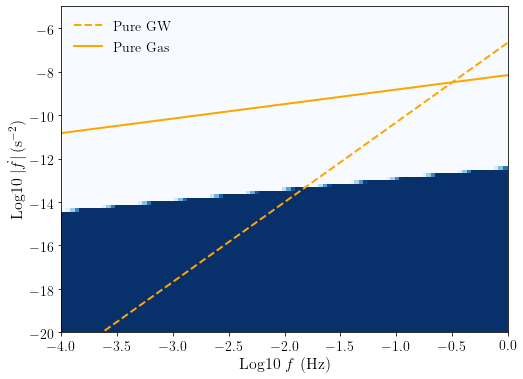

In [38]:
fdot_min = (1./(5.*year))/(5.*year)
fddot_min = (2./(5.*year))/(5.*year)**2.

print("\n\nMin fdot:\t{0}".format(fdot_min))
print("Min fddot:\t{0}".format(fddot_min))

fs = np.logspace(-4,0,100)
fdots = np.logspace(-20,-5,95)
F,FD = np.meshgrid(fs,fdots)
fddots = (11./3.)*FD**2./F

fig,ax = plt.subplots(figsize=(8,6))
cs = ax.pcolormesh(np.log10(fs),np.log10(fdots),np.log10(fddots),cmap='Blues')
contours = ax.contour(np.log10(fs),np.log10(fdots),np.log10(fddots),colors='black',inline=True)
fig.colorbar(cs).set_label(label=r'Log10 $|\ddot f|\,(\mathrm{s}^{-3})$',size=15)
ax.set_xlim(-4,0)
ax.set_ylim(-20,-5)
ax.set_xlabel(r'Log10 $f$ (Hz)',fontsize=16)
ax.set_ylabel(r'Log10 $|\dot f|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14,frameon=False)
plt.show()

FD[FD<fdot_min] = fdot_min
fddots[fddots<fddot_min] = fddot_min
Ns = F*fddots/FD**2.

fig,ax = plt.subplots(figsize=(8,6))
cs = ax.pcolormesh(np.log10(fs),np.log10(fdots),Ns,cmap='Blues',vmax=5)

xs = 10.**np.linspace(-4,0,100)
ys = fdotGW_from_fGW_Mc(xs,compute_Mc(0.5,0.8))
ax.plot(np.log10(xs),np.log10(ys),lw=2,color='orange',ls='--',label='Pure GW')
ax.plot(np.log10(f_ref),np.log10(fdot_drag),lw=2,color='orange',label='Pure Gas')

#fig.colorbar(cs)

ax.set_xlim(-4,0)
ax.set_ylim(-20,-5)
ax.set_xlabel(r'Log10 $f$ (Hz)',fontsize=16)
ax.set_ylabel(r'Log10 $|\dot f|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14,frameon=False)

plt.show()

3.6666666666666665
3.6666666666666665
3.666666666666666
3.6666666666666665
3.666666666666666
3.6666666666666665
3.6666666666666665
3.6666666666666665
3.666666666666666
3.6666666666666665


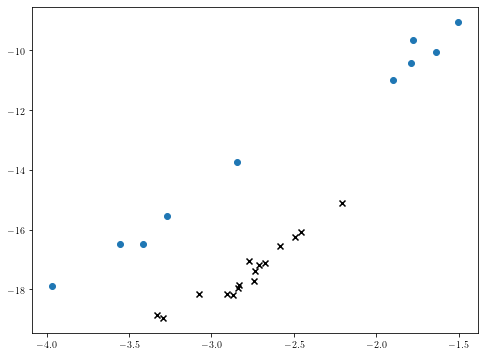

In [92]:
fig,ax = plt.subplots(figsize=(8,6))

fs = np.array([])
fdots = np.array([])

for i in range(10):
    
    m1 = np.random.random()*80.+10
    m2 = np.random.random()*80.+10
    
    f = 10.**(np.random.random()*(-3.)-1.)
    fdot = fdotGW_from_fGW_Mc(f,compute_Mc(m1,m2))
    fddot = 11./3.*fdot**2./f
    
    print(fddot*f/fdot**2.)
    
    fs = np.append(fs,f)
    fdots = np.append(fdots,fdot)
    
ax.scatter(np.log10(fs),np.log10(fdots))
ax.scatter(np.log10(wd_fs),np.log10((96./5.)*np.power(np.pi,8./3.)*np.power(c,-5.)*np.power(G*Mcs*Msun,5./3.)*np.power(wd_fs,11./3.)),marker='x',color='black')

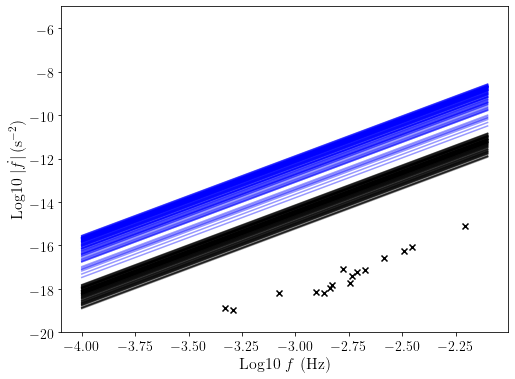

In [31]:
fig,ax = plt.subplots(figsize=(8,6))

fs = np.array([])
fdots = np.array([])

for i in range(100):
    
    m1 = np.random.random()*80.+10
    m2 = np.random.random()*80.+10
    
    f = 10.**(np.arange(-4,-2,0.1))
    fdot = fdotGW_from_fGW_Mc(f,Mc(m1,m2))
    
    #fs = np.append(fs,f)
    #fdots = np.append(fdots,fdot)
    ax.plot(np.log10(f),np.log10(fdot),color='black',alpha=0.4)
    
for i in range(100):
    
    m1 = np.random.random()*3e5+1e5
    m2 = np.random.random()*50
    
    f = 10.**(np.arange(-4,-2,0.1))
    fdot = fdotGW_from_fGW_Mc(f,Mc(m1,m2))
    
    #fs = np.append(fs,f)
    #fdots = np.append(fdots,fdot)
    ax.plot(np.log10(f),np.log10(fdot),color='blue',alpha=0.4)
    
#ax.scatter(np.log10(fs),np.log10(fdots))
ax.set_xlabel(r'Log10 $f$ (Hz)',fontsize=16)
ax.set_ylabel(r'Log10 $|\dot f|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.tick_params(labelsize=14)
ax.set_ylim(-20,-5)
ax.scatter(np.log10(wd_fs),np.log10((96./5.)*np.power(np.pi,8./3.)*np.power(c,-5.)*np.power(G*Mcs*Msun,5./3.)*np.power(wd_fs,11./3.)),marker='x',color='black')

# 